In [1]:
import datetime as dt

import gym
import pandas as pd
import quantstats as qs
from stable_baselines3 import A2C, DQN, PPO
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np
import matplotlib.pyplot as plt

from dailyenv import DailyTradingEnv

c:\Users\olith\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
# tickers = ["AMM", "CIMB", "DIGI", "GAM", "GENM", "GENT", "HLBK", "IOI", "KLK", "MAY", "MISC", "NESZ", "PBK", "PEP", "PETD", "PTG", "RHBBANK", "ROTH", "T", "TNB"]
tickers = ["NESZ"]

train_env = DailyTradingEnv(tickers, dt.datetime(2001, 1, 1), dt.datetime(2018, 1, 1))
val_env = DailyTradingEnv(tickers, dt.datetime(2018, 1, 1), dt.datetime(2020, 1, 1))


In [ ]:
class CustomCallback(BaseCallback):

    def __init__(self, model, freq=100):
        super(CustomCallback, self).__init__()
        self.freq = freq
        self.cash = pd.DataFrame(columns=["TS"] + [f"N{i}" for i in range(11)])
        self.stock = pd.DataFrame(columns=["TS"] + [f"N{i}" for i in range(11)] + ["Min", "Max"])
        self.total_reward = [0]

        super().init_callback(model)

    def _on_step(self) -> bool:

        self.total_reward.append(self.total_reward[-1] + self.training_env.get_attr("last_reward")[0])

        if self.num_timesteps % self.freq != 0:
            return True
        
        cash_row = {"TS": self.num_timesteps}
        stock_row = {"TS": self.num_timesteps}
        thresh_min = None
        thresh_max = None
        for i in range(11):
            pred, _ = self.model.predict(np.array([i/10]), deterministic=True)
            cash_row[f"N{i}"] = pred[0].item()
            stock_row[f"N{i}"] = pred[1].item()
            if thresh_max is not None and pred[1] == 1:
                thresh_max = i
            if thresh_min is None and pred[1] == 1:
                thresh_min = i
                thresh_max = i
        
        if thresh_min is None:
            thresh_min = thresh_max = 0

        stock_row["Min"] = thresh_min
        stock_row["Max"] = thresh_max
        
        self.cash = self.cash.append([cash_row])
        self.stock = self.stock.append([stock_row])
        
        return True

    def _on_training_end(self) -> None:
        self.cash = self.cash.set_index("TS")
        self.stock = self.stock.set_index("TS")
        self.cash.to_csv("cash4.csv")
        self.stock.to_csv("stock4.csv")

        np.savetxt("reward4.csv", self.total_reward, delimiter=",")

        plt.plot(list(range(len(self.total_reward))), self.total_reward)
        plt.show()

In [ ]:
# Test threshold

baseline_results = []

for threshold in range(11):
    obs = train_env.reset()
    done = False
    bal = [train_env.current_balance]
    total_reward = 0
    while not done:
        if obs[0] * 10 >= threshold:
            action = np.array([0, 1])
        else:
            action = np.array([1, 0])


        obs, reward, done, _ = train_env.step(action)
        bal.append(train_env.current_balance)
        total_reward += reward

    returns = pd.Series(bal, index=train_env.day_data_df[tickers[0]].index[:-1])
    new_row = {"Models": threshold, "Train Tot. Reward": total_reward, "Train Sharpe": qs.stats.sharpe(returns), "Train CAGR%": qs.stats.cagr(returns)}
    baseline_results.append(new_row)

for threshold in range(11):
    obs = val_env.reset()
    done = False
    bal = [val_env.current_balance]
    total_reward = 0
    while not done:
        if obs[0] * 10 >= threshold:
            action = np.array([0, 1])
        else:
            action = np.array([1, 0])


        obs, reward, done, _ = val_env.step(action)
        bal.append(val_env.current_balance)
        total_reward += reward

    returns = pd.Series(bal, index=val_env.day_data_df[tickers[0]].index[:-1])
    baseline_results[threshold]["Val Tot. Reward"] = total_reward
    baseline_results[threshold]["Val Sharpe"] = qs.stats.sharpe(returns)
    baseline_results[threshold]["Val CAGR%"] = qs.stats.cagr(returns)

pd.DataFrame(baseline_results).set_index("Models").to_csv("Baseline.csv")

Training

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 4.43e+03 |
|    ep_rew_mean        | 0.366    |
| time/                 |          |
|    fps                | 1077     |
|    iterations         | 100      |
|    time_elapsed       | 23       |
|    total_timesteps    | 25000    |
| train/                |          |
|    entropy_loss       | -1.37    |
|    explained_variance | -0.53    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.00865 |
|    value_loss         | 7.74e-05 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 4.43e+03 |
|    ep_rew_mean        | 0.479    |
| time/                 |          |
|    fps                | 974      |
|    iterations         | 200      |
|    time_elapsed 

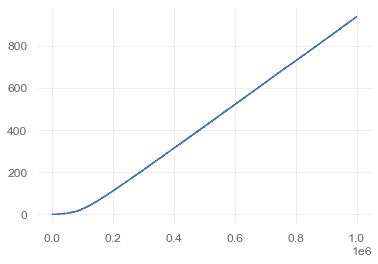

In [9]:
model = A2C("MlpPolicy", train_env, verbose=1, n_steps=250, gamma=0)
# model = DQN("MlpPolicy", train_env, verbose=1)
model.learn(total_timesteps=1000000,  callback=CustomCallback(model))

In [4]:
obs = train_env.reset()
done = False
bal = [train_env.current_balance]
while not done:
    action, _ = model.predict(obs, deterministic=True)

    obs, _, done, _ = train_env.step(action)
    bal.append(train_env.current_balance)

    if done:
        print(train_env.current_balance)

returns = pd.Series(bal, index=train_env.day_data_df[tickers[0]].index[:-1])
print(returns)
print(qs.stats.sharpe(returns))
print(qs.stats.cagr(returns))

14602886.459612016
Dates
2001-01-01    1.000000e+05
2001-01-02    9.857170e+04
2001-01-03    9.857170e+04
2001-01-04    9.952390e+04
2001-01-05    1.000000e+05
                  ...     
2017-12-25    1.443309e+07
2017-12-26    1.415009e+07
2017-12-27    1.413594e+07
2017-12-28    1.443309e+07
2017-12-29    1.460289e+07
Length: 4435, dtype: float64
2.3521503028303408
0.3406005968529673


Validation

In [5]:
obs = val_env.reset()
done = False
bal = [val_env.current_balance]
while not done:
    action, _ = model.predict(obs, deterministic=True)

    obs, _, done, _ = val_env.step(action)
    bal.append(val_env.current_balance)

    if done:
        print(val_env.current_balance)

returns = pd.Series(bal, index=val_env.day_data_df[tickers[0]].index[:-1])
print(returns)
print(qs.stats.sharpe(returns))
print(qs.stats.cagr(returns))

144359.6000000002
Dates
2018-01-01    100000.0
2018-01-02     97967.2
2018-01-03     98839.3
2018-01-04     99033.1
2018-01-05    100195.9
                ...   
2019-12-25    143871.6
2019-12-26    143383.6
2019-12-27    144359.6
2019-12-30    144359.6
2019-12-31    144359.6
Length: 522, dtype: float64
1.244305601577433
0.20179998478904748


In [6]:
import numpy as np
for i in range(11):
    print(i, model.predict(np.array([i/10]), deterministic=True))

0 (array([1., 0.], dtype=float32), None)
1 (array([1., 0.], dtype=float32), None)
2 (array([0., 0.], dtype=float32), None)
3 (array([0., 1.], dtype=float32), None)
4 (array([0., 1.], dtype=float32), None)
5 (array([0., 1.], dtype=float32), None)
6 (array([0., 1.], dtype=float32), None)
7 (array([0., 1.], dtype=float32), None)
8 (array([0., 1.], dtype=float32), None)
9 (array([0., 1.], dtype=float32), None)
10 (array([0., 1.], dtype=float32), None)
